<a href="https://colab.research.google.com/github/krutarth45/Quora-Insincere-Question-Classification/blob/master/SentimentplusSincerityClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Tensrflow

In [0]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 4.3MB 36.7MB/s 
     |████████████████████████████████| 501kB 47.6MB/s 


### Extracting the Dataset from the Kaggle.com

In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/kaggle/kaggle.json

chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [0]:
!kaggle competitions download -c quora-insincere-questions-classification

  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 135MB/s]
 67% 37.0M/54.9M [00:00<00:00, 19.6MB/s]
100% 54.9M/54.9M [00:00<00:00, 66.6MB/s]
100% 5.94G/5.96G [02:16<00:00, 40.1MB/s]
100% 5.96G/5.96G [02:16<00:00, 46.9MB/s]
 32% 5.00M/15.8M [00:00<00:00, 14.9MB/s]
100% 15.8M/15.8M [00:00<00:00, 36.5MB/s]


### Unziping the Data

In [0]:
## Extracting training dataset.
import zipfile
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

In [0]:
## Extracting testing dataset.
with zipfile.ZipFile('test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

### Importing necessary Libraries.

In [0]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm, tqdm_notebook
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D, Bidirectional, GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.models import Sequential


### Reading the DataFrame.

In [0]:
## Reading Dataset
train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


### Using VADER Obtaining the sentiments of the sentence.

In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 13.3MB/s 


In [0]:
# Vader sentiment cell
print('\nGetting sentiments...')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
sia = SIA()
sentiments = np.zeros(len(train_df))
# for _, row in train_df.sample(10).iterrows():
#     print(row.question_text, sia.polarity_scores(row.question_text))

for i, (_, row) in tqdm_notebook(enumerate(train_df.iterrows()), total=len(train_df)):
    sentiments[i] = sia.polarity_scores(row.question_text)['compound']

train_df['sentiment'] = pd.Series(sentiments)
train_df['sentiment_target'] = (train_df['sentiment'] + 1) / 2


Getting sentiments...


In [0]:
#Get correlation between strong polarity and insincerity
print('\nCorrelations to polarity:')
# train_df['strong_polarity'] = pd.Series((train_df['sentiment'] >= 0.5) | (train_df['sentiment'] <= -0.5)).astype(int)
train_df['polarity'] = train_df['sentiment'].abs()
print('Pearson ', train_df['target'].corr(train_df['polarity'], method='pearson'))
print('Kendall ', train_df['target'].corr(train_df['polarity'], method='kendall'))
print('Spearman', train_df['target'].corr(train_df['polarity'], method='spearman'))


Correlations to polarity:
Pearson  0.12127156289036413
Kendall  0.10655835691357328
Spearman 0.12145747422805657


In [0]:
train_df.head()

,qid,question_text,target,sentiment,sentiment_target,polarity
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,0.0000,0.5000,0.0000
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,0.6124,0.8062,0.6124
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,0.0000,0.5000,0.0000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,0.0000,0.5000,0.0000
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,0.0000,0.5000,0.0000


In [0]:
train_df.describe()

,target,sentiment,sentiment_target,polarity
count,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06
mean,6.187018e-02,7.215470e-02,5.360773e-01,2.414038e-01
std,2.409197e-01,3.534403e-01,1.767202e-01,2.680495e-01
min,0.000000e+00,-9.902000e-01,4.900000e-03,0.000000e+00
25%,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,5.000000e-01,1.280000e-01
75%,0.000000e+00,3.612000e-01,6.806000e-01,4.466000e-01
max,1.000000e+00,9.924000e-01,9.962000e-01,9.924000e-01


### Splitting, Tokenizing and Padding.

In [0]:
# some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1)

# fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

# Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

# Get the target values
train_y = train_df[['target', 'sentiment_target']].values
val_y = val_df[['target','sentiment_target']].values

### Using the GloVe Embedding.

In [0]:
## Extracting Embeddings dataset.
with zipfile.ZipFile('embeddings.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

In [0]:
## Extracting the embeddings
EMBEDDING_FILE = '/content/sample_data/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


### Creating the model

In [0]:
## Creating Model
model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix]))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(2, activation="sigmoid"))

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.003), metrics=['accuracy'])
## Printing summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         15000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          85248     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,085,378
Trainable params: 15,085,378
Non-trainable params: 0
__________________________________________

In [0]:
## Training
history = model.fit(train_X, train_y, batch_size=1024, epochs=3, validation_data=(val_X, val_y),verbose=2)

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 - 264s - loss: 0.3748 - accuracy: 0.4774 - val_loss: 0.3656 - val_accuracy: 0.4796
Epoch 2/3
1175509/1175509 - 258s - loss: 0.3620 - accuracy: 0.4809 - val_loss: 0.3653 - val_accuracy: 0.4794
Epoch 3/3
1175509/1175509 - 254s - loss: 0.3560 - accuracy: 0.4831 - val_loss: 0.3672 - val_accuracy: 0.4790


In [0]:
## Predicting for the test data
pred = model.predict(test_X)

In [0]:
import matplotlib.pyplot as plt
## Plotting the curve for the accuracy and the loss
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

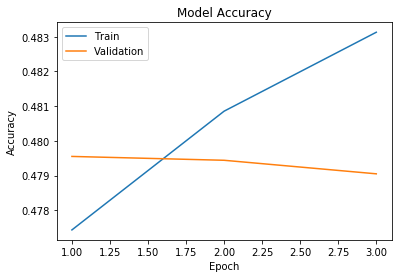

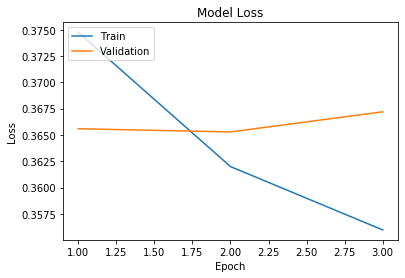

In [0]:
plotLearningCurve(history,3)